In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install scipy

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.8 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 647.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/41.2 MB 2.6 MB/s eta 0:00:16
   ---------------------------------------- 0.3/41.2 MB 3.2 MB/s eta 0:00:14
    --------------------------------------- 0.6/41.2 MB 5.7 MB/s eta 0:00:08
   - -------------------------------------- 1.3/41.2 MB 8.0 MB/s eta 0:00:05
   - -------------------------------------- 1.8/41.2 MB 8.7 MB/s eta 0:00:05
   -- ------------------------------------- 2.5/41.2 MB 10.0 MB/s eta 0:00:04
   -- ------------------------------------- 3.1/41.2 MB 10.9 MB/s eta 0:00:04
   --- ------------------------------------ 3.7/41.2 MB 11.4 MB/s eta 0:00:04
   --- ------------------------------------ 4.0/41.2 MB 11.2 MB/s eta 0:00:04
 


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Found 44400 images belonging to 37 classes.
Found 11100 images belonging to 37 classes.
Epoch 1/30
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0484 - loss: 14.4033 - top_3_accuracy: 0.1307

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.15020, saving model to best_model.keras
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 2079s 1s/step - accuracy: 0.0484 - loss: 14.4025 - top_3_accuracy: 0.1307 - val_accuracy: 0.1502 - val_loss: 10.6708 - val_top_3_accuracy: 0.3736 - learning_rate: 1.0000e-04
Epoch 2/30
   1/1387 ━━━━━━━━━━━━━━━━━━━━ 12:19 534ms/step - accuracy: 0.1250 - loss: 10.8649 - top_3_accuracy: 0.3125

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.15020
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 1512s 1s/step - accuracy: 0.1250 - loss: 10.8649 - top_3_accuracy: 0.3125 - val_accuracy: 0.1473 - val_loss: 10.7229 - val_top_3_accuracy: 0.3698 - learning_rate: 1.0000e-04
Epoch 3/30
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1799 - loss: 10.0200 - top_3_accuracy: 0.3935
Epoch 3: val_accuracy improved from 0.15020 to 0.28802, saving model to best_model.keras
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 2280s 2s/step - accuracy: 0.1799 - loss: 10.0193 - top_3_accuracy: 0.3936 - val_accuracy: 0.2880 - val_loss: 7.4850 - val_top_3_accuracy: 0.5735 - learning_rate: 1.0000e-04
Epoch 4/30
   1/1387 ━━━━━━━━━━━━━━━━━━━━ 24:17 1s/step - accuracy: 0.2812 - loss: 7.3004 - top_3_accuracy: 0.6562
Epoch 4: val_accuracy did not improve from 0.28802
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 336s 242ms/step - accuracy: 0.2812 - loss: 7.3004 - top_3_accuracy: 0.6562 - val_accuracy: 0.2880 - val_loss: 7.5202 - val_top_3_accuracy: 0

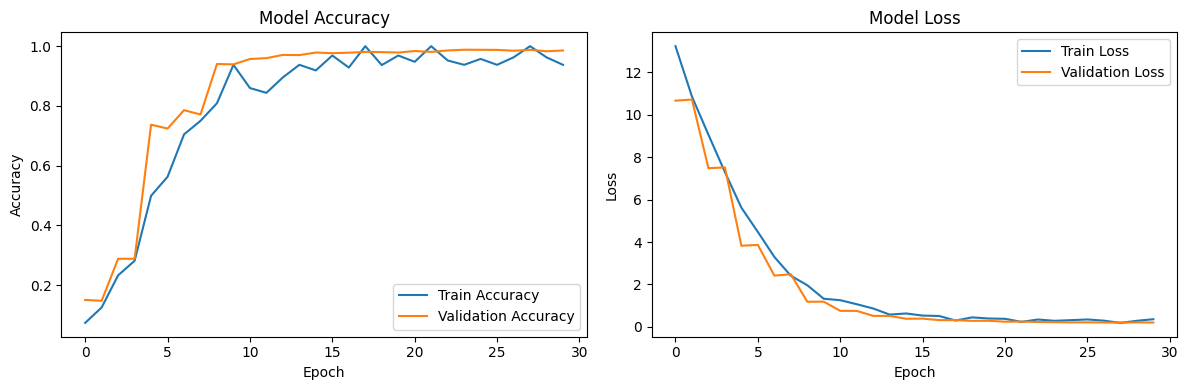


Evaluating model on validation set...
347/347 ━━━━━━━━━━━━━━━━━━━━ 281s 807ms/step - accuracy: 0.9841 - loss: 0.2299 - top_3_accuracy: 0.9977
Validation Accuracy: 0.9860
Validation Top-3 Accuracy: 0.9987


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import pickle
import os
import matplotlib.pyplot as plt

# Constants
DATASET_PATH = r"C:\Users\ADMIN\Documents\sign_language_project\Gesture Image Pre-Processed Data"
IMG_SIZE = (224, 224)  # EfficientNetB0 default input size
BATCH_SIZE = 32
EPOCHS = 30
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 1e-4
MIN_LEARNING_RATE = 1e-7
DROPOUT_RATE = 0.5
L2_REGULARIZATION = 0.01

# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

# Data generators
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Save class labels
with open("class_labels.pkl", "wb") as f:
    pickle.dump(train_generator.class_indices, f)

# Load Pretrained EfficientNetB0
base_model = EfficientNetB0(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling=None
)

# Gradual unfreezing strategy - freeze first 150 layers initially
base_model.trainable = True
for layer in base_model.layers[:150]:
    layer.trainable = False

# Build Enhanced Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(DROPOUT_RATE),
    Dense(512, activation='relu', kernel_regularizer=l2(L2_REGULARIZATION)),
    BatchNormalization(),
    Dropout(DROPOUT_RATE),
    Dense(256, activation='relu', kernel_regularizer=l2(L2_REGULARIZATION)),
    BatchNormalization(),
    Dropout(DROPOUT_RATE * 0.8),  # Slightly less dropout in final layers
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Improved Model Compilation
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
    ]
)

# Callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=MIN_LEARNING_RATE,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )
]

# Train Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Save the final model in Keras format
model.save("sign_language_model.keras")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_history(history)

# Evaluate the model
print("\nEvaluating model on validation set...")
val_loss, val_acc, val_top3_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Top-3 Accuracy: {val_top3_acc:.4f}")